# FIDS Custom FL Server
Created March 24, 2023

This notebook creates the server for a federated intrusion detection system (FIDS) using a custom class which has been implemented in our GitHub module. In this implementation, the clients are running on separate runtimes which pass model parameters using a shared Google Drive folder.

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download SynCAN dataset repository, combine train files, and clean directory
!git clone https://github.com/etas/SynCAN.git &> /dev/null
%cd /content/SynCAN
!unzip \*.zip -d . &> /dev/null
!cat train_*.csv > train.csv
!rm *.zip &> /dev/null
%cd /content

# download project repository
!git clone https://github.com/brendon-felix/VehicleCybersecFL.git &> /dev/null
!rm ./VehicleCybersecFL/*.ipynb &> /dev/null
!cp -r ./VehicleCybersecFL/anomalydetection/* .
%run anomalydetection.py
%run id_labels.py

/content/SynCAN
/content


In [ ]:
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'GPU: {gpu_info[599:619]}')
ram_gb = virtual_memory().total / 1e9
print(f'RAM: {ram_gb:.1f} GB')

GPU: 
RAM: 13.6 GB


In [ ]:
# id 2 timesteps 100
# id 10 timsteps 100
# id 5 timesteps 250
# id 2 timesteps 250
# id 10 timesteps 250

In [ ]:
id = 2
time_steps = 100
params = {
    'id': id,
    'train_split': 0.6,
    'val_split': 0.2,
    'warm_up': time_steps//5,
    'time_steps': time_steps,
    'seq_stride': 2,
    'batch_size': 100,
    'drop_out': True,
    'attention': True,
    'loss_function': 'mse',
    'learning_rate': 0.00001,
    'metric': 'mae',
    'epochs_per_round': 1,
    'num_clients': 3,
    'patience': 1,
    'num_iterations': 10,
    'model_dir': '/content/drive/MyDrive/Senior Design 22-23/Models/FIDS'+str(time_steps)+'/id'+str(id)+'/',
}
directory = '/content/drive/MyDrive/Senior Design 22-23/Models/'
save_params(params, directory)

# Prepare Data


In [ ]:
train_df = import_data('SynCAN/train.csv', params['msg_id'])
thresh_df = train_df.iloc[:len(train_df)//5]

29,669,725 total messages (id1,id2,...,id10)
2,070,144 messages used (id2)
0 anomalous messages out of 2,070,144



In [ ]:
continuous_df = import_data('SynCAN/test_continuous.csv', params['msg_id'])
plateau_df = import_data('SynCAN/test_plateau.csv', params['msg_id'])
continuous_df = clean_labels(continuous_df, params['msg_id'], real_anomaly_ranges[params['msg_id']]['continuous'])
plateau_df = clean_labels(plateau_df, params['msg_id'], real_anomaly_ranges[params['msg_id']]['plateau'])

2,150,051 total messages (id1,id2,...,id10)
150,016 messages used (id2)
20,043 anomalous messages out of 150,016

2,150,051 total messages (id1,id2,...,id10)
150,016 messages used (id2)
24,483 anomalous messages out of 150,016



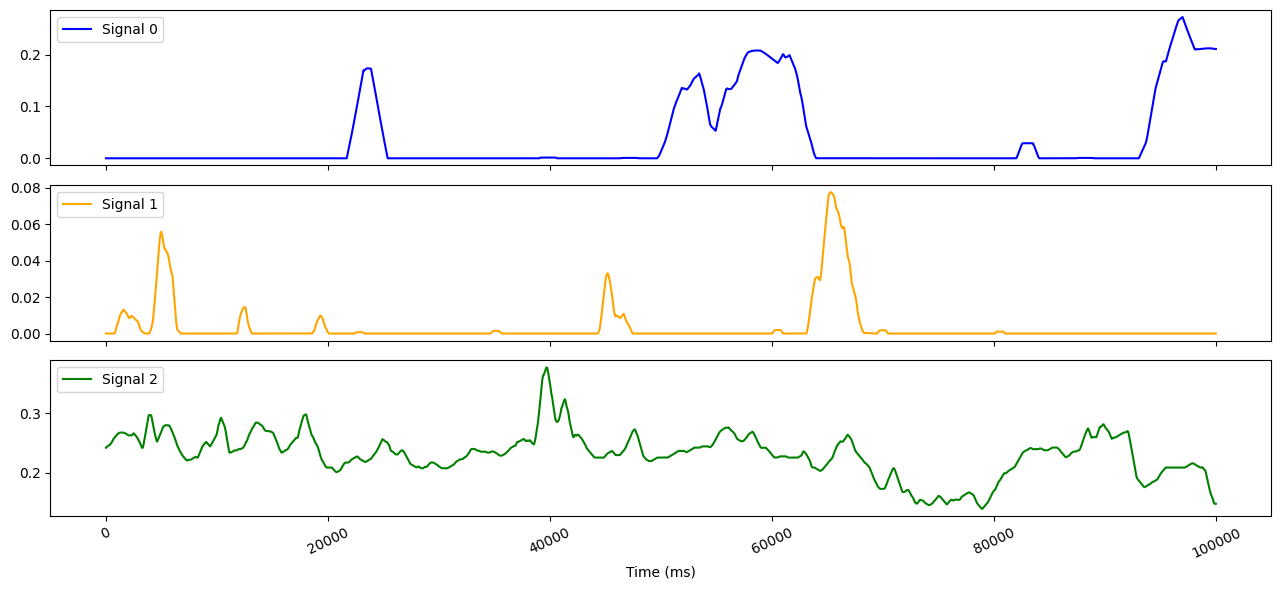

In [ ]:
visualize_data(train_df, end_time=1e5)

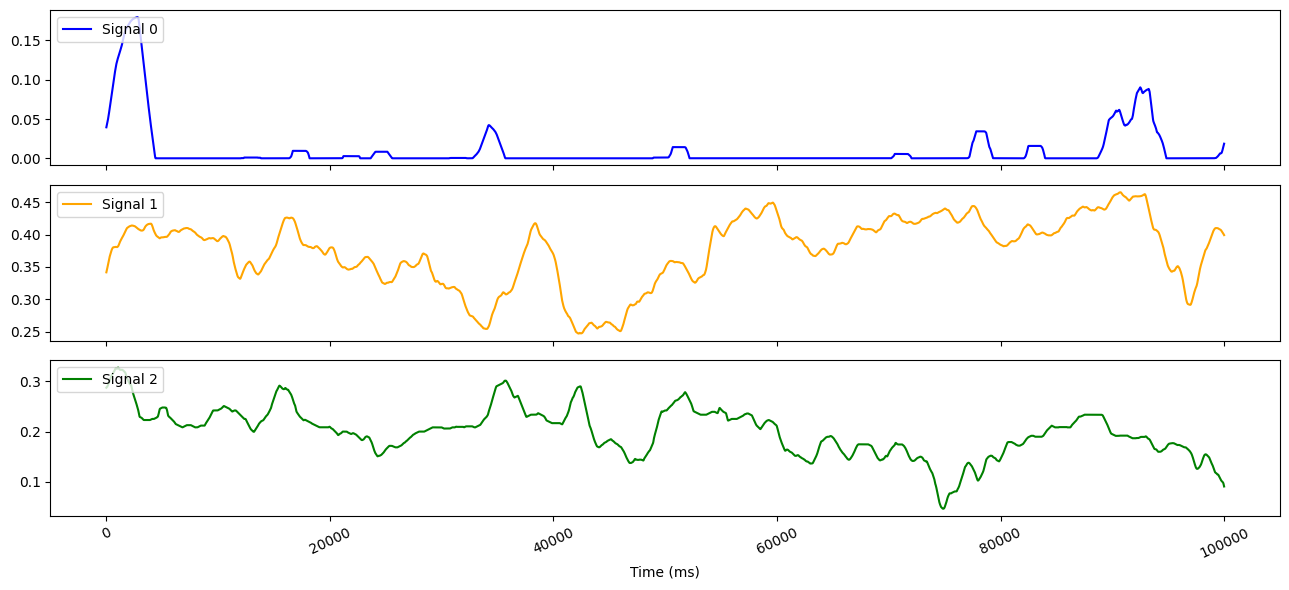

In [ ]:
visualize_data(continuous_df, end_time=1e5)

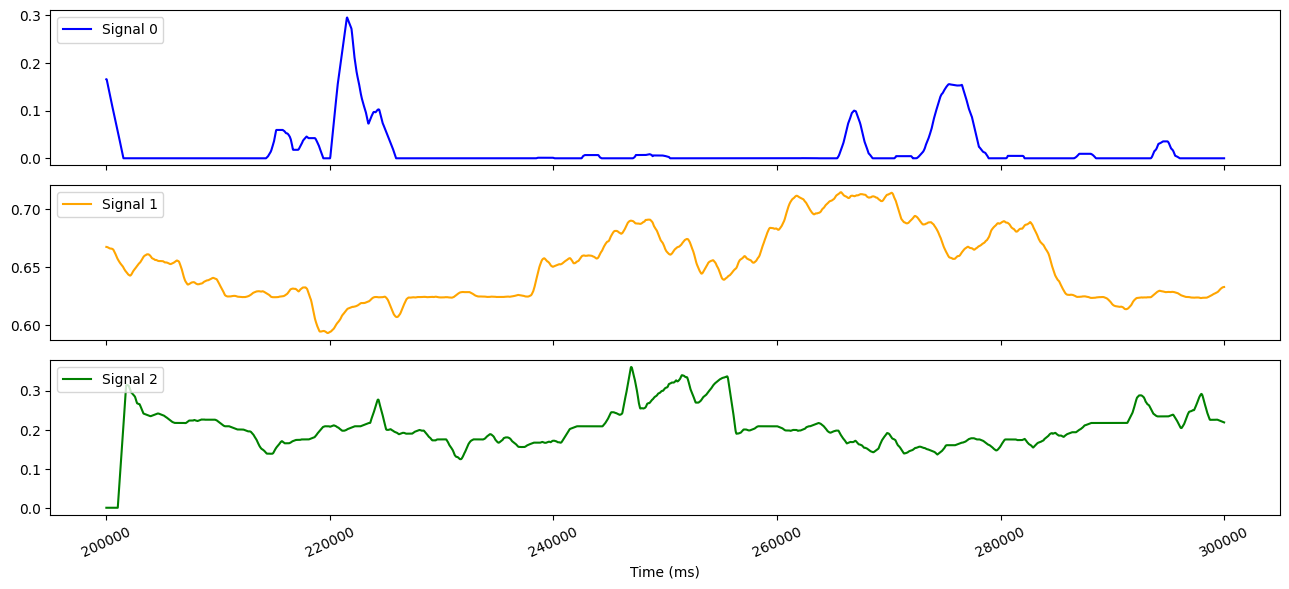

In [ ]:
visualize_data(plateau_df, start_time=2e5, end_time=3e5)

# Train and Aggregate

In [ ]:
fl = FederatedLearning(params, train_df, verbose=True)

Using model directory /content/drive/MyDrive/Senior Design 22-23/Models/FIDS100/id2/
Train:
620,983 subsequences of length 100
6,210 batches (batch size 100)

Val:
206,954 subsequences of length 100
2,070 batches (batch size 100)

Test:
206,955 subsequences of length 100
2,070 batches (batch size 100)



In [ ]:
fl.run_server(validation=False, test=False)

Starting Server...
Initializing global model...
Iteration 1/10
Loading client models...
Waiting for client 0...

Waiting for client 2...
Aggregating client models...
Iteration 2/10
Loading client models...
Waiting for client 0...
Waiting for client 1...

Aggregating client models...
Iteration 3/10
Loading client models...
Waiting for client 0...


Aggregating client models...
Iteration 4/10
Loading client models...
Waiting for client 0...
Waiting for client 1...
Waiting for client 2...
Aggregating client models...
Iteration 5/10
Loading client models...
Waiting for client 0...


Aggregating client models...
Iteration 6/10
Loading client models...
Waiting for client 0...

Waiting for client 2...
Aggregating client models...
Iteration 7/10
Loading client models...
Waiting for client 0...


Aggregating client models...
Iteration 8/10
Loading client models...
Waiting for client 0...
Waiting for client 1...

Aggregating client models...
Iteration 9/10
Loading client models...
Waiting for cl

# Evaluate Global Model

In [ ]:
evaluator = SynCAN_Evaluator(thresh_df, params, verbose=True)

Creating threshold dataset...
82,794 subsequences of length 50
828 batches (batch size 100)


In [ ]:
# model = fl.aggregator.global_model
model = tf.keras.models.load_model(params['model_dir'] + 'global_model_10.h5')

In [ ]:
evaluator.evaluate(model, continuous_df, thresh_stds=4)

Reconstructing threshold-selection data...
828/828 [==============================] - 34s 40ms/step
Setting squared-error thresholds...
Signal 1: 0.0032164
Signal 2: 0.00041709
11,998 subsequences of length 50
120 batches (batch size 100)
Reconstructing evaluation data...
120/120 [==============================] - 4s 36ms/step
Labeling reconstructed subsequences...
Creating predictions...
Accuracy: 0.53217
Balanced Accuracy: 0.53545
F1 Score: 0.038046
Precision Score: 0.019719
Recall Score: 0.53883


Plotting reconstruction...


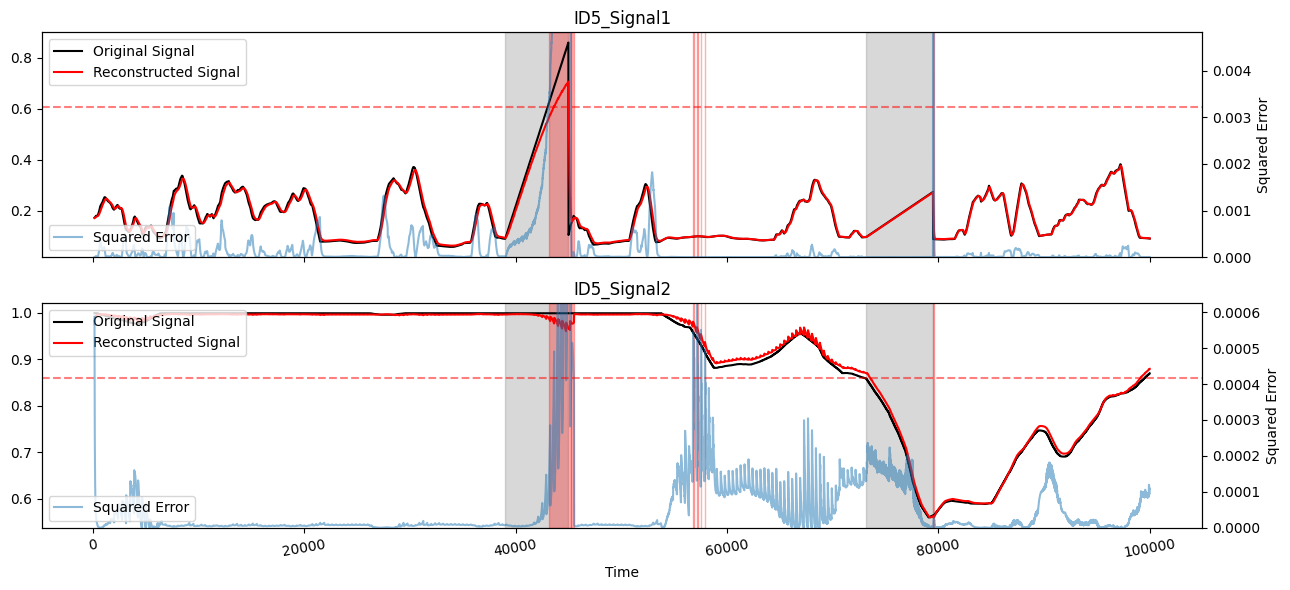

In [ ]:
evaluator.visualize_reconstruction(
    start_time=0,
    end_time=1e5,
    highlight_anomalies=True,
    highlight_predictions=True,
    plot_squared_error=True
)

In [ ]:
evaluator.evaluate(model, plateau_df, thresh_stds=4)

Reconstructing threshold-selection data...
828/828 [==============================] - 34s 42ms/step
Setting squared-error thresholds...
Signal 1: 0.0032164
Signal 2: 0.00041709
11,998 subsequences of length 50
120 batches (batch size 100)
Reconstructing evaluation data...
120/120 [==============================] - 4s 36ms/step
Labeling reconstructed subsequences...
Creating predictions...
Accuracy: 0.57593
Balanced Accuracy: 0.58093
F1 Score: 0.068473
Precision Score: 0.03636
Recall Score: 0.58621


Plotting reconstruction...


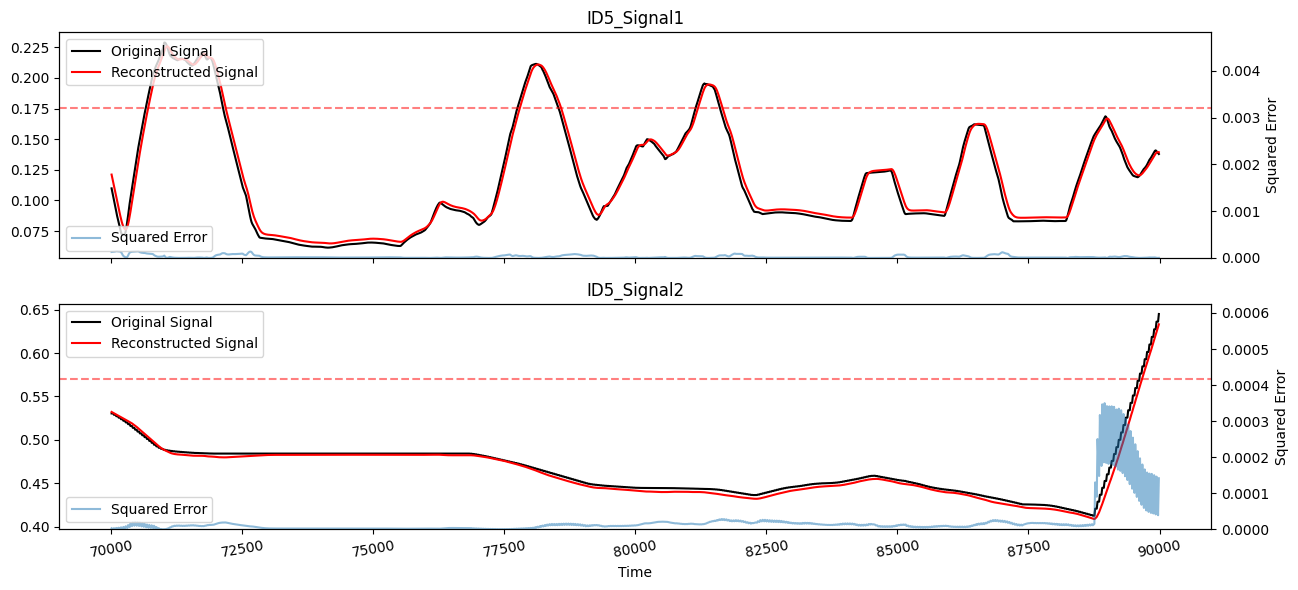

In [ ]:
evaluator.visualize_reconstruction(
    start_time=7e4,
    end_time=9e4,
    highlight_anomalies=True,
    highlight_predictions=True,
    plot_squared_error=True
)